# 3 Feature Engineering

In [40]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_processing import load_grant_data
from src.api_fetcher import fetch_cdc_wonder_data, enrich_with_demographics

import warnings
warnings.filterwarnings('ignore')

## Load Cleaned Data

In [41]:
df = pd.read_csv('../data/processed/mchb_grants_cleaned.csv')

print(f"Loaded {len(df)} grants")
print(f"Columns: {df.columns.tolist()}")
df.head()

Loaded 1839 grants
Columns: ['Program Area', 'Program Name', 'Fiscal Year', 'Activity Code', 'Grant Number', 'Grantee Name', 'State', 'County', 'Congressional District', 'Grantee Class', 'Awardee Amount', 'Grantee Contact Details', 'program_category', 'is_outlier', 'fiscal_year', 'is_mental_health', 'is_maternal_health', 'log_amount']


,Program Area,Program Name,Fiscal Year,Activity Code,Grant Number,Grantee Name,State,County,Congressional District,Grantee Class,Awardee Amount,Grantee Contact Details,program_category,is_outlier,fiscal_year,is_mental_health,is_maternal_health,log_amount
0,Maternal and Child Health,Healthy Start Initiative-Eliminating Racial/Et...,2021,H49,H49MC27827,Birmingham Healthy Start Plus Inc,AL,Jefferson,AL-06,"Corporate Entity, Federal Tax Exempt",1269121.0,"1105 52nd St S Birmingham, AL 35222-3924",Maternal Health,False,2021,False,True,6.103503
1,Maternal and Child Health,Maternal and Child Health Nutrition Training P...,2021,T79,T79MC00011,University Of Alabama At Birmingham,AL,Jefferson,AL-07,Other,225000.0,"701 20th St S Birmingham, AL 35233-2031",Maternal Health,False,2021,False,True,5.352183
2,Maternal and Child Health,Leadership Education in Adolescent Health (LEAH),2021,T71,T71MC24209,University Of Alabama At Birmingham,AL,Jefferson,AL-07,Other,437942.0,"701 20th St S Birmingham, AL 35233-2031",Training & Education,False,2021,False,False,5.641417
3,Maternal and Child Health,Leadership Education in Neurodevelopmental and...,2021,T73,T73MC00003,University Of Alabama At Birmingham,AL,Jefferson,AL-07,Other,713466.0,"701 20th St S Birmingham, AL 35233-2031",Training & Education,False,2021,False,False,5.853373
4,Maternal and Child Health,Pediatric Pulmonary Centers,2021,T72,T72MC00001,University Of Alabama At Birmingham,AL,Jefferson,AL-07,Other,340000.0,"701 20th St S Birmingham, AL 35233-2031",Other,False,2021,False,False,5.531479


## Aggregate to State Level

In [42]:
# Basic aggregation total funding and grant counts by state
state_summary = df.groupby('State').agg({
    'Awardee Amount': ['sum', 'mean', 'median', 'count'],
    'Grant Number': 'count'
}).reset_index()

state_summary.columns = ['state', 'total_funding', 'avg_grant', 'median_grant', 'num_grants', 'grant_count_check']

# Drop duplicate count column
state_summary = state_summary.drop('grant_count_check', axis=1)

print("State-level summary created:")
print(state_summary.head())

State-level summary created:
  state  total_funding     avg_grant  median_grant  num_grants
0    AK     17845634.0  8.497921e+05     1051991.0          21
1    AL    115695593.0  4.285022e+06     1150000.0          27
2    AR     91357304.0  3.806554e+06     4076542.0          24
3    AS      8650892.0  5.088760e+05      490242.0          17
4    AZ    118347190.0  4.226685e+06     1173276.5          28


## Add Program-Specific Funding

In [43]:
# Mental health funding by state
mh_funding = df[df['is_mental_health'] == True].groupby('State').agg({
    'Awardee Amount': 'sum'
}).reset_index()
mh_funding.columns = ['state', 'mental_health_funding']

# Maternal health funding by state
maternal_funding = df[df['is_maternal_health'] == True].groupby('State').agg({
    'Awardee Amount': 'sum'
}).reset_index()
maternal_funding.columns = ['state', 'maternal_health_funding']

# Merge into state summary
state_summary = state_summary.merge(mh_funding, on='state', how='left')
state_summary = state_summary.merge(maternal_funding, on='state', how='left')

# Fill NaN with 0
state_summary['mental_health_funding'] = state_summary['mental_health_funding'].fillna(0)
state_summary['maternal_health_funding'] = state_summary['maternal_health_funding'].fillna(0)

print("Added program-specific funding columns")
print(state_summary[['state', 'total_funding', 'mental_health_funding', 'maternal_health_funding']].head())

Added program-specific funding columns
  state  total_funding  mental_health_funding  maternal_health_funding
0    AK     17845634.0               407116.0               15324103.0
1    AL    115695593.0               395128.0              111258871.0
2    AR     91357304.0                    0.0               87948829.0
3    AS      8650892.0                    0.0                8091143.0
4    AZ    118347190.0                    0.0              114693447.0


## Calculate Program Diversity

In [44]:
# Count unique program categories per state
program_diversity = df.groupby('State')['program_category'].nunique().reset_index()
program_diversity.columns = ['state', 'num_program_types']

# Merge
state_summary = state_summary.merge(program_diversity, on='state', how='left')

print("Program diversity added:")
print(state_summary[['state', 'num_grants', 'num_program_types']].head(10))

Program diversity added:
  state  num_grants  num_program_types
0    AK          21                  8
1    AL          27                  8
2    AR          24                  7
3    AS          17                  6
4    AZ          28                  7
5    CA          84                  8
6    CO          42                  8
7    CT          29                  8
8    DC          57                  8
9    DE          23                  8


## CDC Health Outcome Data

In [45]:
health_data = fetch_cdc_wonder_data(year=2021)

print(f"Fetched health data for {len(health_data)} states")
print("\nHealth metrics included:")
print(health_data.columns.tolist())
print("\nSample:")
print(health_data.head())

Fetching CDC health outcome data...
Retrieved data for 50 states
Fetched health data for 50 states

Health metrics included:
['state', 'state_fips', 'year', 'infant_mortality_rate', 'prenatal_care_pct', 'low_birthweight_pct', 'preterm_birth_pct', 'maternal_mortality_rate']

Sample:
  state  state_fips  year  infant_mortality_rate  prenatal_care_pct  \
0    AL           1  2021                   6.19               84.3   
1    AK           2  2021                   5.20               70.9   
2    AZ           4  2021                   4.59               84.5   
3    AR           5  2021                   5.33               74.6   
4    CA           6  2021                   7.25               72.1   

   low_birthweight_pct  preterm_birth_pct  maternal_mortality_rate  
0                  9.9               11.0                     17.3  
1                 10.5               11.0                     25.6  
2                 10.3                9.1                     17.7  
3             

## Add Demographics

In [46]:
# demographic data
health_data = enrich_with_demographics(health_data)

print("Demographics added:")
print(health_data[['state', 'median_household_income', 'poverty_rate', 'uninsured_rate']].head())

Adding demographic variables...
Demographics added:
  state  median_household_income  poverty_rate  uninsured_rate
0    AL                  59982.0          21.6             4.4
1    AK                  83029.0          18.9            12.9
2    AZ                  74280.0          21.2             8.4
3    AR                  68946.0          20.5            11.1
4    CA                  51241.0          16.4            16.7


## Merge Everything Together

In [47]:
# Merge state
full_data = state_summary.merge(health_data, on='state', how='inner')

print(f"Merged dataset: {len(full_data)} states")
print(f"Total columns: {len(full_data.columns)}")
print("\nColumns:")
print(full_data.columns.tolist())

Merged dataset: 50 states
Total columns: 19

Columns:
['state', 'total_funding', 'avg_grant', 'median_grant', 'num_grants', 'mental_health_funding', 'maternal_health_funding', 'num_program_types', 'state_fips', 'year', 'infant_mortality_rate', 'prenatal_care_pct', 'low_birthweight_pct', 'preterm_birth_pct', 'maternal_mortality_rate', 'median_household_income', 'poverty_rate', 'uninsured_rate', 'urban_pct']


In [48]:
# Any states that didn't match
states_in_grants = set(state_summary['state'])
states_in_health = set(health_data['state'])

missing_from_health = states_in_grants - states_in_health
if missing_from_health:
    print(f"States in grant data but not health data: {missing_from_health}")
else:
    print("All states matched! Good to go.")

States in grant data but not health data: {'AS', 'FM', 'MH', 'GU', 'VI', 'PW', 'DC', 'MP', 'PR'}


## Create Derived Features

In [49]:
# Mental health funding as percentage of total
full_data['mental_health_pct'] = (full_data['mental_health_funding'] / full_data['total_funding'] * 100).round(2)

# Maternal health funding as percentage of total  
full_data['maternal_health_pct'] = (full_data['maternal_health_funding'] / full_data['total_funding'] * 100).round(2)

# Log transform of total funding
full_data['log_total_funding'] = np.log10(full_data['total_funding'])

# Create funding categories
funding_terciles = full_data['total_funding'].quantile([0.33, 0.67])
def categorize_funding(x):
    if x < funding_terciles[0.33]:
        return 'Low'
    elif x < funding_terciles[0.67]:
        return 'Medium'
    else:
        return 'High'

full_data['funding_category'] = full_data['total_funding'].apply(categorize_funding)

print("New features created:")
print(full_data[['state', 'total_funding', 'mental_health_pct', 'funding_category']].head())

New features created:
  state  total_funding  mental_health_pct funding_category
0    AK     17845634.0               2.28              Low
1    AL    115695593.0               0.34           Medium
2    AR     91357304.0               0.00           Medium
3    AZ    118347190.0               0.00           Medium
4    CA    394132863.0               0.11             High


## Add Regional Variables

In [50]:
# Define regions
regions = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

# Create mapping
state_to_region = {}
for region, states in regions.items():
    for state in states:
        state_to_region[state] = region

# Map it to data
full_data['region'] = full_data['state'].map(state_to_region)

# Handle territories
full_data['region'] = full_data['region'].fillna('Territory/Other')

print("Regions assigned:")
print(full_data['region'].value_counts())

Regions assigned:
region
South        16
West         13
Midwest      12
Northeast     9
Name: count, dtype: int64


## Check of the Final Dataset

In [51]:
print("Final dataset summary:")
print(f"States: {len(full_data)}")
print(f"Features: {len(full_data.columns)}")
print(f"\nMissing values:")
print(full_data.isnull().sum()[full_data.isnull().sum() > 0])

Final dataset summary:
States: 50
Features: 24

Missing values:
Series([], dtype: int64)


In [52]:
full_data.head(10)

,state,total_funding,avg_grant,median_grant,num_grants,mental_health_funding,maternal_health_funding,num_program_types,state_fips,year,...,maternal_mortality_rate,median_household_income,poverty_rate,uninsured_rate,urban_pct,mental_health_pct,maternal_health_pct,log_total_funding,funding_category,region
0,AK,17845634.0,8.497921e+05,1051991.0,21,407116.0,15324103.0,8,2,2021,...,25.6,83029.0,18.9,12.9,57.0,2.28,85.87,7.251532,Low,West
1,AL,115695593.0,4.285022e+06,1150000.0,27,395128.0,111258871.0,8,1,2021,...,17.3,59982.0,21.6,4.4,90.4,0.34,96.17,8.063317,Medium,South
2,AR,91357304.0,3.806554e+06,4076542.0,24,0.0,87948829.0,7,5,2021,...,19.4,68946.0,20.5,11.1,69.5,0.00,96.27,7.960743,Medium,South
3,AZ,118347190.0,4.226685e+06,1173276.5,28,0.0,114693447.0,7,4,2021,...,17.7,74280.0,21.2,8.4,52.2,0.00,96.91,8.073158,Medium,West
4,CA,394132863.0,4.692058e+06,300000.0,84,445000.0,369616494.0,8,6,2021,...,21.8,51241.0,16.4,16.7,94.3,0.11,93.78,8.595643,High,West
5,CO,103856811.0,2.472781e+06,375000.0,42,445000.0,95454528.0,8,8,2021,...,15.7,51240.0,20.9,7.5,57.1,0.43,91.91,8.016435,Medium,West
6,CT,90036528.0,3.104708e+06,915440.0,29,445000.0,86137010.0,8,9,2021,...,29.5,47323.0,9.2,9.7,78.6,0.49,95.67,7.954419,Medium,Northeast
7,DE,33482061.0,1.455742e+06,535583.0,23,412266.0,30880379.0,8,10,2021,...,21.6,79647.0,10.7,14.6,83.1,1.23,92.23,7.524812,Low,South
8,FL,190593344.0,4.143334e+06,435761.5,46,445000.0,184786807.0,8,12,2021,...,18.9,69045.0,8.6,7.2,56.9,0.23,96.95,8.280108,High,South
9,GA,157235321.0,4.249603e+06,824491.0,37,445000.0,152482228.0,8,13,2021,...,17.8,73323.0,12.6,5.1,81.4,0.28,96.98,8.196550,High,South


In [53]:
# Basic stats on key variables
print("Key variable statistics:")
print(full_data[['total_funding', 'mental_health_funding', 'infant_mortality_rate', 
                 'prenatal_care_pct', 'poverty_rate']].describe())

Key variable statistics:
       total_funding  mental_health_funding  infant_mortality_rate  \
count   5.000000e+01           5.000000e+01              50.000000   
mean    1.121909e+08           3.877643e+05               6.772000   
std     8.125400e+07           2.776415e+05               1.346369   
min     8.747901e+06           0.000000e+00               4.540000   
25%     5.242440e+07           4.084035e+05               5.605000   
50%     1.076245e+08           4.450000e+05               6.830000   
75%     1.442296e+08           4.450000e+05               8.017500   
max     3.941329e+08           1.645000e+06               8.860000   

       prenatal_care_pct  poverty_rate  
count          50.000000     50.000000  
mean           77.232000     14.922000  
std             4.367573      4.298518  
min            70.200000      8.100000  
25%            73.375000     11.050000  
50%            77.450000     15.100000  
75%            80.850000     18.800000  
max            8

## Visualization

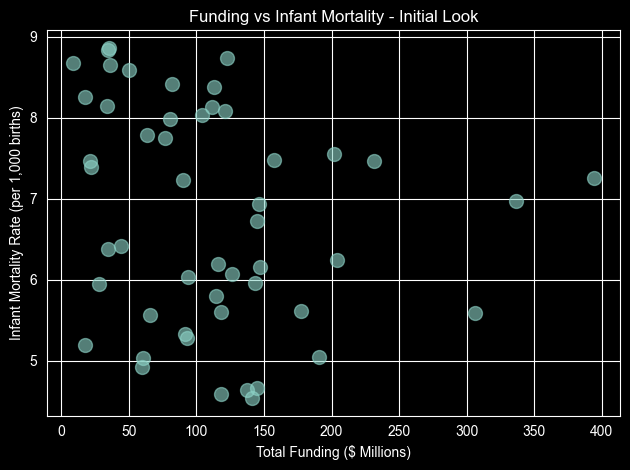


Correlation: -0.205


In [54]:
# Scatter plot funding correlate and infant mortality
fig, ax = plt.subplots()

ax.scatter(full_data['total_funding'] / 1e6, full_data['infant_mortality_rate'], 
           alpha=0.6, s=100)

ax.set_xlabel('Total Funding ($ Millions)')
ax.set_ylabel('Infant Mortality Rate (per 1,000 births)')
ax.set_title('Funding vs Infant Mortality - Initial Look')


plt.tight_layout()
plt.show()

# correlation
corr = full_data['total_funding'].corr(full_data['infant_mortality_rate'])
print(f"\nCorrelation: {corr:.3f}")

## Save Final Dataset

In [55]:
# Save to processed folder
output_path = '../data/processed/state_analysis_data.csv'
full_data.to_csv(output_path, index=False)

print(f"Saved final dataset to {output_path}")
print(f"Ready for statistical analysis!")

Saved final dataset to ../data/processed/state_analysis_data.csv
Ready for statistical analysis!
